In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

- So far we have seen **different types of neural network architectures**, each with its own purpose.... However, there are proprietary **neural network architectures** that are used to handle **unstructured data or sequence data.**

In [ ]:
with open('/content/names.txt',mode='r',encoding ='utf-8') as f:
  words=f.read().split()

In [ ]:
vocab = sorted(set(list(''.join(words))))

In [ ]:
# build the vocabulary of characters and mapping to /from integers
stoi = {s:i+1 for i , s in enumerate(vocab)}
stoi['.'] = 0
# reverse mapping
itos = {i:s for  s,i in stoi.items()}

In [ ]:
vocab_size = len(itos)

In [ ]:
def build_dataset(words):

  X,Y = [],[]

  block_size = 3
  context=[0]*block_size
  for w in words:
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context=context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)

  return X,Y

In [ ]:
block_size=3

In [ ]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1]) #  80%
Xdev,Ydev = build_dataset(words[n1:n2]) #  10%
Xte,yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
for x,y  in zip(Xtr[:20],Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x),'----->',itos[y.item()])

... -----> y
..y -----> u
.yu -----> h
yuh -----> e
uhe -----> n
hen -----> g
eng -----> .
ng. -----> d
g.d -----> i
.di -----> o
dio -----> n
ion -----> d
ond -----> r
ndr -----> e
dre -----> .
re. -----> x
e.x -----> a
.xa -----> v
xav -----> i
avi -----> e


In [ ]:
class Linear:

  def __init__(self,fan_in, fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out))/fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------

class BactNorm1d:

  def __init__(self,dim,eps = 1e-5 , momentun = 0.1):
    self.eps = eps
    self.dim = dim
    self.training = True
    self.momentun = momentun
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.zeros(dim)

  def __call__(self,x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(axis = 0, keepdims = True) # batch mean
      xvar  = x.var(axis = 0, keepdims = True,unbiased=False) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentun) * self.running_mean + self.momentun * xmean
        self.running_var =  (1 - self.momentun ) * self.running_var + self.momentun * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ===============================================================================

class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

#  ==============================================================================

class Embedding:

  def __init__(self, num_embbeding,embedding_dim):
    self.weight = torch.randn(num_embbeding, embedding_dim)

  def __call__(self,IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# ===================================================================================

class Flatten:

  def __call__(self,x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []
# ====================================================================================

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for  layer in self.layers for p in layer.parameters()]

In [ ]:
torch.manual_seed(42)

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size,n_embd))
layers = [
    Linear(n_embd * block_size,n_hidden,bias = False),BactNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
]


# parameter init

with torch.no_grad():
  layers[-1].weight *=0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parametrs in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
layers[0].weight.shape

torch.Size([30, 200])

In [ ]:
batch_size = 32
max_steps = 100000
lossi = []

for  i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,))
  Xb,Yb = Xtr[ix],Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)  # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # ------------------------------------------------------

  # update
  lr = 0.1 if i  < 10000 else 0.01
  for p  in parameters:
    p.data+=-lr*p.grad

  # strack stats
  if i % 1000 == 0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 100000:3.2942
   1000/ 100000:2.4622
   2000/ 100000:2.1842
   3000/ 100000:2.0944
   4000/ 100000:2.7029
   5000/ 100000:2.2654
   6000/ 100000:2.3630
   7000/ 100000:2.1481
   8000/ 100000:2.0242
   9000/ 100000:2.7153
  10000/ 100000:2.2967
  11000/ 100000:2.2796
  12000/ 100000:2.6312
  13000/ 100000:2.1767
  14000/ 100000:2.2464
  15000/ 100000:2.2891
  16000/ 100000:2.2033
  17000/ 100000:2.2928
  18000/ 100000:2.3083
  19000/ 100000:2.4530
  20000/ 100000:2.4117
  21000/ 100000:2.1189
  22000/ 100000:2.0110
  23000/ 100000:2.1092
  24000/ 100000:2.3762
  25000/ 100000:1.8521
  26000/ 100000:2.0461
  27000/ 100000:2.2146
  28000/ 100000:2.3322
  29000/ 100000:2.1003
  30000/ 100000:2.0994
  31000/ 100000:1.8094
  32000/ 100000:2.1395
  33000/ 100000:2.3228
  34000/ 100000:1.7025
  35000/ 100000:2.4312
  36000/ 100000:2.2826
  37000/ 100000:2.0036
  38000/ 100000:2.1246
  39000/ 100000:1.9792
  40000/ 100000:2.2902
  41000/ 100000:2.0530
  42000/ 100000:1.9076
  43000/ 10

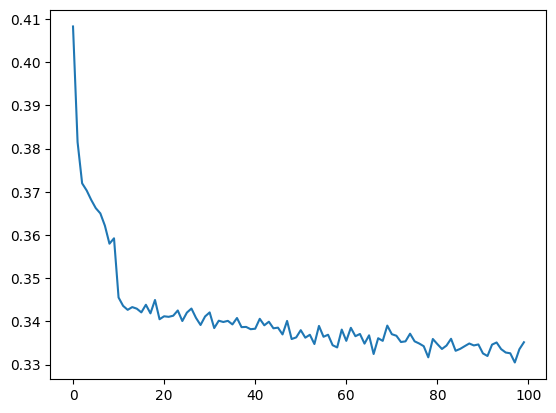

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# evaluate loss

@torch.no_grad()
def split_loss(split):
  x,y = {
      "train" : (Xtr,Ytr),
       "val" : (Xdev,Ydev),
       "test" : (Xte,yte),
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  for layer in layers:
    embcat = layer(embcat)
  loss = F.cross_entropy(embcat,y)
  print(split,loss.item())

split_loss("train")
split_loss("val")
split_loss("test")

train 2.138444185256958
val 2.1652019023895264
test 2.1627817153930664


In [ ]:
random.seed(74802398923)

In [ ]:
# sampling from  the model

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0], -1 )
    for layer in layers:
      x = layer(x)
    logits =  x
    probs = F.softmax(logits, dim = 1)
    # sample from distribuition
    ix = torch.multinomial(probs,num_samples = 1).item()
    # shift the context window and  track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token , break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode an print the generated word

.
nie.
axsu.
ia.
reeoet.
namiwiieyieaaeaza.
ahyaeeiy.
nm.
eyesauy.
mutea.
.
atooev.
eyiayyieisnaalnreiaarliiie.
iloeaimizeo.
nl.
aajleiimaei.
.
eazaeey.
ikaihrynial.
aae.


#**1-Pytorchifying our code: layers, containers, torch.nn, fun bugs**

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP


model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(n_embd * block_size,n_hidden,bias = False),BactNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
])


# parameter init

with torch.no_grad():
  layers[-1].weight *=0.1 # last layer make less confident

parameters = model.parameters()
for p in parameters:
  p.requires_grad = True

In [ ]:
batch_size = 32
max_steps = 100000
lossi = []

for  i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,))
  Xb,Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)  # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # ------------------------------------------------------

  # update : simple SGD
  lr = 0.1 if i  < 10000 else 0.01 # step learning rate decay
  for p  in parameters:
    p.data +=-lr*p.grad

  # strack stats
  if i % 1000 == 0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 100000:3.6171
   1000/ 100000:2.6368
   2000/ 100000:2.6105
   3000/ 100000:2.2022
   4000/ 100000:2.3626
   5000/ 100000:2.3368
   6000/ 100000:2.7961
   7000/ 100000:2.5002
   8000/ 100000:2.0566
   9000/ 100000:2.6126
  10000/ 100000:2.3351
  11000/ 100000:2.1542
  12000/ 100000:2.1243
  13000/ 100000:1.9587
  14000/ 100000:2.4531
  15000/ 100000:2.3611
  16000/ 100000:2.1068
  17000/ 100000:2.4524
  18000/ 100000:1.7260
  19000/ 100000:2.3880
  20000/ 100000:2.3349
  21000/ 100000:2.6142
  22000/ 100000:2.1667
  23000/ 100000:2.1569
  24000/ 100000:2.2626
  25000/ 100000:2.0646
  26000/ 100000:2.1896
  27000/ 100000:2.2645
  28000/ 100000:2.4424
  29000/ 100000:2.5290
  30000/ 100000:2.2225
  31000/ 100000:2.1941
  32000/ 100000:2.4178
  33000/ 100000:1.9398
  34000/ 100000:2.1791
  35000/ 100000:2.0962
  36000/ 100000:2.2838
  37000/ 100000:2.4047
  38000/ 100000:2.2463
  39000/ 100000:2.1700
  40000/ 100000:1.8619
  41000/ 100000:1.8770
  42000/ 100000:2.4787
  43000/ 10

In [ ]:
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate loss

@torch.no_grad()
def split_loss(split):
  x,y = {
      "train" : (Xtr,Ytr),
       "val" : (Xdev,Ydev),
       "test" : (Xte,yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss("train")
split_loss("val")
split_loss("test")

train 2.1374034881591797
val 2.166473150253296
test 2.1620118618011475


In [ ]:

# sampling from  the model

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim = 1)
    # sample from distribuition
    ix = torch.multinomial(probs,num_samples = 1).item()
    # shift the context window and  track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token , break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode an print the generated word

ruhi.
raste.
ruley.
zuia.
hiah.
jazlyn.
daivi.
shono.
saisie.
evania.
iat.
rumilian.
riah.
ecr.
zardyana.
ron.
ster.
wynn.
riofa.
iste.


#**2-WaveNet**

- **Dataset bump the context size to 8**

In [ ]:
def build_dataset(words):

  X,Y = [],[]

  block_size = 8
  context=[0]*block_size
  for w in words:
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context=context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)

  return X,Y

In [ ]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1]) #  80%
Xdev,Ydev = build_dataset(words[n1:n2]) #  10%
Xte,yte = build_dataset(words[n2:]) # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
block_size = 8


model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(n_embd * block_size,n_hidden,bias = False),BactNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
])


# parameter init

with torch.no_grad():
  layers[-1].weight *=0.1 # last layer make less confident

print(sum(p.nelement() for p in model.parameters()))
parameters = model.parameters()
for p in parameters:
  p.requires_grad = True

22097


#**3-re-running baseline code on block_size 8**

In [ ]:
batch_size = 32
max_steps = 100000
lossi = []

for  i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,))
  Xb,Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)  # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # ------------------------------------------------------

  # update : simple SGD
  lr = 0.1 if i  < 10000 else 0.01 # step learning rate decay
  for p  in parameters:
    p.data +=-lr*p.grad

  # strack stats
  if i % 1000 == 0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 100000:3.3113
   1000/ 100000:2.2246
   2000/ 100000:2.3994
   3000/ 100000:2.2765
   4000/ 100000:2.2016
   5000/ 100000:2.1266
   6000/ 100000:2.4595
   7000/ 100000:2.0983
   8000/ 100000:2.0935
   9000/ 100000:2.3368
  10000/ 100000:2.7713
  11000/ 100000:2.3873
  12000/ 100000:1.9231
  13000/ 100000:2.2478
  14000/ 100000:2.1796
  15000/ 100000:2.1846
  16000/ 100000:1.9582
  17000/ 100000:2.6345
  18000/ 100000:2.2512
  19000/ 100000:2.4475
  20000/ 100000:1.8236
  21000/ 100000:2.0362
  22000/ 100000:2.0693
  23000/ 100000:2.7328
  24000/ 100000:2.1109
  25000/ 100000:2.5008
  26000/ 100000:2.2587
  27000/ 100000:2.0016
  28000/ 100000:2.7417
  29000/ 100000:2.7404
  30000/ 100000:2.2335
  31000/ 100000:2.2457
  32000/ 100000:1.9875
  33000/ 100000:1.8498
  34000/ 100000:2.3231
  35000/ 100000:1.9072
  36000/ 100000:2.0036
  37000/ 100000:2.3085
  38000/ 100000:2.3493
  39000/ 100000:2.6058
  40000/ 100000:1.7889
  41000/ 100000:2.2009
  42000/ 100000:2.4788
  43000/ 10

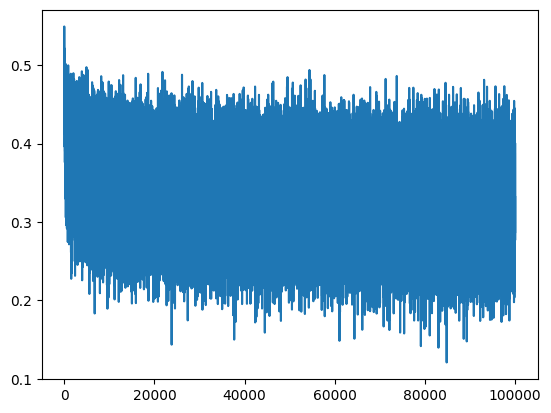

In [ ]:
plt.plot(lossi)

In [ ]:
# evaluate loss

@torch.no_grad()
def split_loss(split):
  x,y = {
      "train" : (Xtr,Ytr),
       "val" : (Xdev,Ydev),
       "test" : (Xte,yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss("train")
split_loss("val")
split_loss("test")

train 2.0951173305511475
val 2.148928165435791
test 2.154147148132324


In [ ]:
for layer in model.layers:
  layer.training = True

In [ ]:
# sampling from  the model

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim = 1)
    # sample from distribuition
    ix = torch.multinomial(probs,num_samples = 1).item()
    # shift the context window and  track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token , break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode an print the generated word

aenaoidinalar.
iialaiaaoaainayaiaeate.
aerayka.
eroeaayalyhaeadiaeeiiaiaeayaaearay.
a.
ayaaera.
naalao.
neiieasheasaeeakeliaaabaayleo.
aa.
eaaiaebiai.
eeaiaa.
eeay.
neynaueoaiaraniyaaatnnzahyaaaiarihaldeaaaiaiyaieseoinaroaaiaoaaeaaea.
rraeeda.
eaiataehatexiaaeeaaeaiieiaieaa.
aaeleenaaaomeveyi.
aleaeviide.
.
aiaau.
ataeaieleiayyaaaai.


In [ ]:
torch.manual_seed(42)

# **4-Implementing WaveNet**

## **Fixing batchnorm1d bug**

In [ ]:
class Linear:

  def __init__(self,fan_in, fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out))/fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------

class BactNorm1d:

  def __init__(self,dim,eps = 1e-5 , momentun = 0.1):
    self.eps = eps
    self.dim = dim
    self.training = True
    self.momentun = momentun
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.zeros(dim)

# ====================================
  def __call__(self,x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif  x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim , keepdims = True) # batch mean
      xvar  = x.var(dim ,  keepdims = True,unbiased = False) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentun) * self.running_mean + self.momentun * xmean
        self.running_var =  (1 - self.momentun ) * self.running_var + self.momentun * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ===============================================================================

class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

#  ==============================================================================

class Embedding:

  def __init__(self, num_embbeding,embedding_dim):
    self.weight = torch.randn((num_embbeding, embedding_dim))

  def __call__(self,IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# ===================================================================================

class FlattenConsecutive:
  def __init__(self,n):
    self.n = n

  def __call__(self,x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []
# ====================================================================================

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for  layer in self.layers for p in layer.parameters()]

In [ ]:
torch.manual_seed(42)

##**4.1-Scaling up the WaveNet**

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP


model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(n_embd   * 2, n_hidden, bias = False), BactNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BactNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BactNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),
])


# parameter init

with torch.no_grad():
  layers[-1].weight *=0.1 # last layer make less confident

print(sum(p.nelement() for p in model.parameters()))

parameters = model.parameters()
for p in parameters:
  p.requires_grad = True

72617


In [ ]:
ix = torch.randint(0,Xtr.shape[0],(4,))
Xb, Yb = Xtr[ix],Ytr[ix]
logits = model(Xb)

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__,":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 128)
BactNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BactNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BactNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [ ]:
batch_size = 32
max_steps = 200000
lossi = []

for  i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,))
  Xb,Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)  # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # ------------------------------------------------------

  # update : simple SGD
  lr = 0.1 if i  < 150000 else 0.01 # step learning rate decay
  for p  in parameters:
    p.data +=-lr*p.grad

  # strack stats
  if i % 10000 == 0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000:3.4163
  10000/ 200000:2.2020
  20000/ 200000:2.0992
  30000/ 200000:1.8820
  40000/ 200000:2.1453
  50000/ 200000:2.3186
  60000/ 200000:1.8566
  70000/ 200000:1.9653
  80000/ 200000:2.1659
  90000/ 200000:1.9317
 100000/ 200000:2.1039
 110000/ 200000:2.0725
 120000/ 200000:1.8852
 130000/ 200000:1.7610
 140000/ 200000:2.1729
 150000/ 200000:1.8798
 160000/ 200000:2.0190
 170000/ 200000:2.0421
 180000/ 200000:1.7609
 190000/ 200000:1.8824


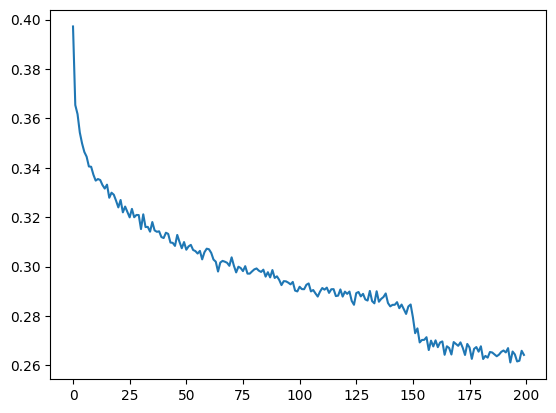

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
for layer in layers:
  layer.training = False

In [ ]:
# evaluate loss

@torch.no_grad()
def split_loss(split):
  x,y = {
      "train" : (Xtr,Ytr),
       "val" : (Xdev,Ydev),
       "test" : (Xte,yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss("train")
split_loss("val")
split_loss("test")

train 1.797673225402832
val 2.061986207962036
test 2.0607025623321533


###**performance log**

- flat - hierarchical (22k params)  train 2.091. val 2.1439

- Scale up the network:n_embd 24,n_hidden 128 (76k params):train 1.7239. val  2.060

In [ ]:
torch.manual_seed(42)

In [ ]:
# sampling from  the model

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim = 1)
    # sample from distribuition
    ix = torch.multinomial(probs,num_samples = 1).item()
    # shift the context window and  track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token , break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode an print the generated word

yeesyaaleaaae.
elaekaimaeaonya.
eayaieaieenaeaaeelyaaiiaeaa.
keaea.
as.
a.
oyaaaaaai.
aeioeannezaseoraaalaa.
oainaeeenayaaayn.
aeoaaartaneaidaemaam.
eiaiinyyranycnaiadaayaneaaaeeiaanayskaaoaaaeyaaalni.
ieilaaaeieeaoaieeyaylasaaaanioemaiyaaaae.
atorsaalelyaiaaesmlsaeeeeaearaaeeeaadeiaalerasliayel.
anai.
aaiaaaroeiaaoaarl.
zaesuenaylaeaii.
aaieseaeiaeeyeaaanianlsnnaiaieincatieaailaaanaoneelaiae.
sshediolaaaaaeoymaraesiaaraomnniano.
eeeaiaadr.
rilei.
